In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xa
from pprint import pprint

fdir = "/home/jungyoung/Project_win/hh_neuralnet/"

import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools

import hhclustering as hc
import utils 

from importlib import reload
reload(utils)

from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from numba import njit

In [2]:
# Load dataset
with open("./data/align_data_sub.pkl", 'rb') as fp:
    align_data_sub = pkl.load(fp)
    
data = align_data_sub["data"].copy()
echelon = np.array([c["rank"] for c in align_data_sub["col_names"]])

# PCA projected datset
eval, evec, _, cov_mat = hc.pca(data)
pca_proj = np.dot(evec.T, data)

def show_pca_proj(pred_labels, **kwargs):
    plt.scatter(pca_proj[0], pca_proj[1], c=pred_labels, s=1, **kwargs)

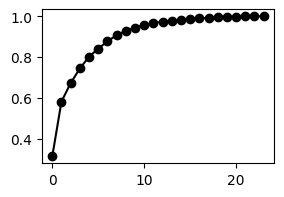

In [3]:
plt.figure(figsize=(3, 2))
plt.plot(np.cumsum(eval/np.sum(eval)), 'ko-')
plt.show()

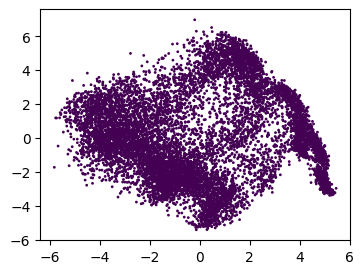

In [4]:
plt.figure(figsize=(4, 3))
show_pca_proj(np.zeros(pca_proj.shape[1]))
plt.show()

## remove lead-lag ratio

In [4]:
data_r = align_data_sub["data"][:-4]
row_labels_r = align_data_sub["row_labels"][:-4]

eval_r, evec_r, _, cov_mat = hc.pca(data_r)
pca_proj_r = np.dot(evec_r.T, data_r)

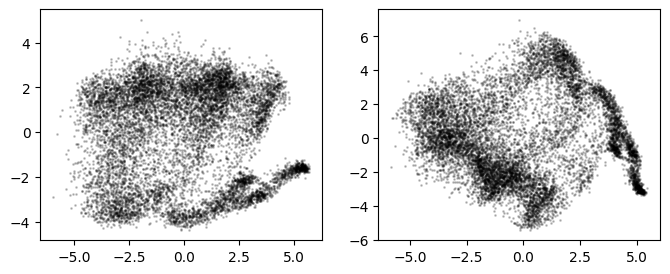

In [5]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(pca_proj_r[0], pca_proj_r[1], 1, 'k', facecolor="none", alpha=0.2)
plt.subplot(122)
plt.scatter(pca_proj[0], pca_proj[1], 1, 'k', facecolor="none", alpha=0.2)
plt.show()

## Check dynamics by index

In [6]:
def get_sq_idx(idx):
    na = idx // (15 * 3 * 16)
    nb = (idx - 15*3*16*na) // (3 * 16)
    nr = (idx - 15*3*16*na - 3*16*nb) // 16
    nw = idx - 15*3*16*na - 3*16*nb - 16*nr
    return na, nb, nr, nw


def get_idx(sq_idx):
    return sq_idx[0]*15*3*16 + sq_idx[1]*3*16 + sq_idx[2]*16 + sq_idx[3]

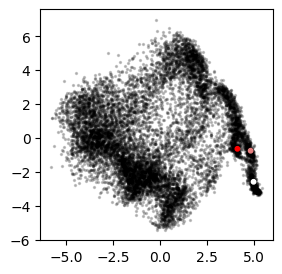

In [7]:
target_idx = [3475, 7714, 7859]

plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0], pca_proj[1],2, 'k', alpha=0.2, facecolor="none")
plt.scatter(pca_proj[0][target_idx], pca_proj[1][target_idx], 10, [[1, 0, 0], [0.9, 0.5, 0.5], [1, 1, 1]])
plt.show()

# plt.figure(figsize=(5, 3))
# for i in target_idx:
#     plt.plot(data[:, i], 'o-')
# plt.show()

In [ ]:
import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal

summary = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)

plt.figure(figsize=(6, 6))
nuse = 1
axs = []
for idx in target_idx:
    idx_sq = get_sq_idx(idx)
    data = summary.load_detail(*idx_sq, 0)

    for v in data["vlfp"]:
        psd, fpsd, tpsd = hhsignal.get_stfft(v, data["ts"], 2000, frange=(5, 100))

        ax = plt.subplot(3, 3, nuse)
        hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic")
        
        nuse += 1
        axs.append(ax)

lbs = ("Total", "Fast", "Slow")
for i in range(3):
    axs[3*i].set_ylabel("#%d\n frequency (Hz)"%(target_idx[i]), fontsize=14)
    axs[6+i].set_xlabel("time (s)", fontsize=14)
    axs[i].set_title("%s"%(lbs[i]), fontsize=14)

plt.tight_layout()
plt.show()

: 

# K-means clustering

In [84]:
# load dataset
from sklearn.metrics import silhouette_score

# load result
# with open("./data/kmeans_pred.pkl", "rb") as fp:
with open("./data/kmeans_pred_partial.pkl", "rb") as fp: # or kmeans_pred
    pred_data = pkl.load(fp)
print(len(pred_data["labels"]))

2700


In [85]:
import warnings
warnings.filterwarnings(action='ignore')

@njit 
def build_consensus_matrix(pred_set, sval_set=None):
    
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    sval_set = np.ones(N) if sval_set is None else sval_set
    cmat = np.zeros((npoint, npoint))
    
    for n in range(N):
        s = sval_set[n]
        pred = pred_set[n]
        for i in range(npoint):
            cmat[i, i] += s
            for j in range(i+1, npoint):
                if pred[i] == pred[j]:
                    cmat[i, j] += s
                # cmat[j, i] = cmat[i, j]
    
    cmat = cmat / cmat[0, 0]
    for i in range(npoint):
        for j in range(i):
            cmat[i, j] = cmat[j, i]
     
    
    return cmat    


# compute sval
# x = align_data_sub["data"]
# N = x.shape[1]
# NC = len(pred_data["labels"])

# pred_sval = np.zeros(NC)
# for i in trange(NC):
#     pred_sval[i] = silhouette_score(x.T, np.array(pred_data["labels"][i]), sample_size=1000)
    
# # compute consensus matrix
# nitr = 100
# e = np.linspace(0, 1, 21)
# ksets = np.arange(3, 30)
# c_hists = []
# # for i in trange(len(ksets)):
# for i in trange(10):
#     # cmat = build_consensus_matrix(pred_data["labels"][i*nitr:(i+1)*nitr], pred_sval[i*nitr:(i+1)*nitr])
#     cmat = build_consensus_matrix(pred_data["labels"][i*nitr:(i+1)*nitr])
#     c, _ = np.histogram(cmat.flatten(), e)
#     c_hists.append(c/np.sum(c))




In [86]:
de = 0.05
e = np.arange(-de/2, 1+de, de)

hists = []
nmax = 100
for n in trange(10):
    pred_labels = np.array(pred_data["labels"][n*nmax:(n+1)*nmax])
    
    cmat = build_consensus_matrix(pred_labels)
    nbin, _ = np.histogram(cmat, e)
    hists.append(nbin/np.sum(nbin))
    
    del cmat
    
with open("./data/consensus_clustering_hists.pkl", "wb") as fp:
    pkl.dump(dict(ksets=np.arange(3, 13), hists=hists, edges=e), fp)    

  0%|          | 0/10 [00:00<?, ?it/s]

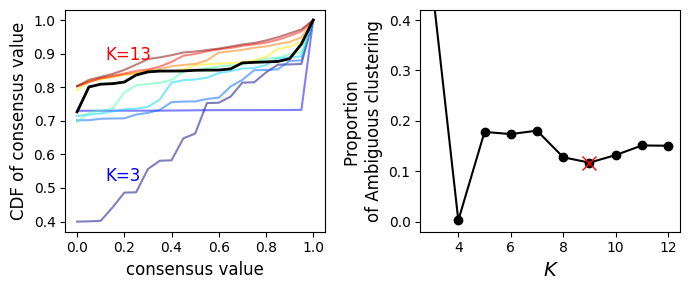

In [87]:
x = (e[1:] + e[:-1])/2
palette = hhtools.get_palette("jet")
ksets = np.arange(3, 13)

nopt = 6

pacs = []
for i in range(len(hists)):
    c = np.cumsum(hists[i])
    pacs.append(c[-2] - c[1])

plt.figure(figsize=(7, 3))
plt.subplot(121)
for i in range(len(hists)):
    plt.plot(x, np.cumsum(hists[i]), c=palette(i/(len(hists)-1)), alpha=0.5)
plt.text(0.12, 0.52, "K=3", fontsize=12, color="b")
plt.text(0.12, 0.88,  "K=13", fontsize=12, color='r')

plt.plot(x, np.cumsum(hists[nopt-1]), lw=2, c='k')
plt.xlabel("consensus value", fontsize=12)
plt.ylabel("CDF of consensus value", fontsize=12)

plt.subplot(122)
plt.plot(ksets, pacs, 'ko-')
plt.plot(ksets[nopt], pacs[nopt], 'rx', markersize=10)
plt.xlabel("K", fontsize=14, fontstyle="italic")
plt.ylabel("Proportion \nof Ambiguous clustering", fontsize=12)

plt.ylim([-0.02, 0.42])

plt.tight_layout()
plt.show()

# Run clustering on optimal K

In [117]:
cmat_opt = build_consensus_matrix(pred_data["labels"][nopt*nmax:(nopt+1)*nmax])
dmat = 1 - cmat_opt
dmat[dmat <= 0] = 0

model_tree = hc.SLHC(metric="precomputed", method="complete")
model_tree.fit(dmat)

In [106]:
cid_tmp = model_tree.cut_dend(N=ksets[nopt])
sq_cid_tmp = np.reshape(cid_tmp, (15, 15, 3, 16))
sq_cid = sq_cid_tmp.copy()

for nr in range(3):
    for nw in range(16):
        tmp = hc.remove_cluster_island(sq_cid_tmp[:, :, nr, nw], nth=6)
        # tmp2 = hc.remove_cluster_island(tmp, nth=3)
        sq_cid[:, :, nr, nw] = hc.remove_cluster_island(tmp, nth=3)
        # sq_cid[:, :, nr, nw] = hc.remove_cluster_island(tmp, nth=6)
        
sq_cid, id_old2new = hc.reorder_sq_cluster_id(sq_cid, start_id=1)
cid = sq_cid.flatten()

In [108]:
# Change Cluster ID manually
# id_change = {"1":1, "2":2, "3":9, "4":3, "5":5, "6":8, "7":6, "8":7, "9":4}
# id_change = [-1, 1, 2, 9, 3, 5, 8, 6, 7, 4]
id_change = [-1, 1, 2, 6, 3, 5, 4, 9, 7, 8]

cid_man = cid.copy()
for i in range(len(id_change)):
    cid_man[cid == i] = id_change[i]

cid = cid_man
sval = silhouette_score(data.T, cid)

In [109]:
from sklearn.metrics import silhouette_samples, silhouette_score

sval = silhouette_samples(data.T, cid)
scoef = silhouette_score(data.T, cid)

postdata = xa.load_dataarray("../three_pop_mpi/simulation_data/postdata.nc")

sz = [15, 15, 3, 16]
dims = ("alpha", "beta", "rank", "w")
coords = coords=dict(
            alpha=postdata.coords["alpha"].data,
            beta=postdata.coords["beta"].data,
            rank=postdata.coords["rank"].data,
            w=postdata.coords["w"].data
        )

cid_dataset = xa.Dataset(
    data_vars=dict(
        cluster_id=(dims, cid.reshape(*sz)),
        sval=(dims, sval.reshape(*sz))
    ),
    coords=coords,
    attrs=dict(
        id_set=np.unique(cid),
        date=utils.get_date_string(),
        scoef=scoef,
        source="kmeans_pred_partial.pkl"
    )
)

cid_dataset.to_netcdf("./data/cluster_id_update_sub.nc")

## Visaulze clustering result

In [110]:
def draw_with_dendrogram(res_linkage, cmat, cluster_id, label=None):
    from scipy.cluster.hierarchy import dendrogram
    
    num = res_linkage.shape[0]
    
    fig = plt.figure(dpi=120, figsize=(6, 6))
    fig.add_axes([0.15, 0.78, 0.65, 0.2])
    dendrogram(res_linkage, no_labels=True, color_threshold=max(res_linkage[:, 2]))
    # dendrogram(res_link, no_labels=True, color_threshold=max(res_link[:, 2])*1)
    plt.yscale("symlog")
    plt.xticks([]); plt.yticks([])
    # plt.xlim([0, num-1])

    fig.add_axes([0.15, 0.75, 0.65, 0.03])
    plt.imshow(cluster_id.reshape((1, -1)), aspect="auto", cmap="Set3", interpolation="none")
    for cid in np.unique(cluster_id):
        x = np.where(cluster_id == cid)[0]
        plt.text(np.average(x), 0, "%d"%(cid), ha='center', va="center")
    plt.xticks([]); plt.yticks([])
    plt.xlim([0, num-1])

    fig.add_axes([0.15, 0.1, 0.65, 0.65])
    plt.imshow(cmat, cmap="jet")
    plt.xlabel(label, fontsize=14)
    plt.ylabel(label, fontsize=14)

    # plt.show()
    return fig

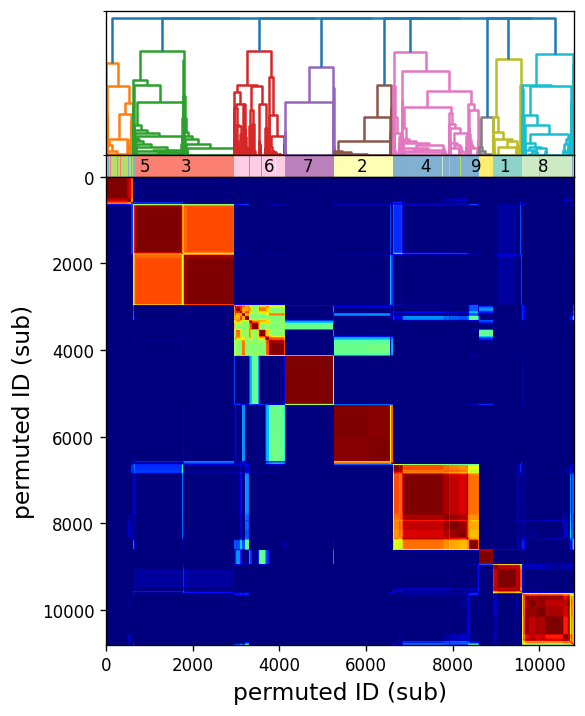

In [118]:
sorted_mat, sort_id = model_tree.sort_dmat(cmat_opt.copy())
fig = draw_with_dendrogram(model_tree.linkmat, sorted_mat, cid[sort_id], label="permuted ID (sub)")

## Compare with previous cluster ID

In [119]:
prev_cid_sub = xa.load_dataset("./data/cluster_id_sub.nc")
prev_cid = prev_cid_sub.cluster_id.data.flatten()

In [120]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

print(adjusted_mutual_info_score(prev_cid, cid))
print(adjusted_rand_score(prev_cid, cid))

0.7891558982743452
0.7632230774812186


### Show contingency table

In [34]:
# @jit(nopython=True)
def gen_contingency_mat(cluster_id1, cluster_id2, sval1=None, sval2=None, sth=0.2):
    
    cid_set1 = np.sort(np.unique(cluster_id1)).astype(int)
    cid_set2 = np.sort(np.unique(cluster_id2)).astype(int)
    cont_mat = np.zeros((len(cid_set1), len(cid_set2)))
    
    N = len(cluster_id1)    
    for n in range(N):
        s1 = sval1[n] if sval1 is not None else 1
        s2 = sval2[n] if sval2 is not None else 1
        if s1 > sth and s2 > sth:
            c1 = int(cluster_id1[n]) - cid_set1[0]
            c2 = int(cluster_id2[n]) - cid_set2[0]
            cont_mat[c1, c2] += 1
    
    return cont_mat, cid_set1, cid_set2


def draw_contingency_table(cont_mat, cid_set1, cid_set2, cid_labels):
    def imshow_auto(im, **kwargs):
        plt.imshow(im, aspect="auto", **kwargs)
        
    def write_num(arr, dir="v"):
        for n, a in enumerate(arr):
            if dir == "v":
                plt.text(0, n, "%d"%(a), fontsize=14, ha="center", va="center")
            elif dir == "h":
                plt.text(n, 0, "%d"%(a), fontsize=14, ha="center", va="center")
                
    N = np.sum(cont_mat)
    
    ax_cont = plt.axes([0.1, 0.1, 0.7, 0.7])
    vmax = N/np.max([len(np.unique(cid_set1)), len(np.unique(cid_set2))])
    imshow_auto(cont_mat, cmap="gray", vmax=vmax, vmin=0)
    plt.xticks(np.arange(len(cid_set2)), labels=cid_set2)
    plt.yticks(np.arange(len(cid_set1)), labels=cid_set1)
    plt.ylabel("cluster ID (%s)"%(cid_labels[0]), fontsize=14)
    plt.xlabel("cluster ID (%s)"%(cid_labels[1]), fontsize=14)
    
    ax_sum1 = plt.axes([0.82, 0.1, 0.1, 0.7]) # right axis
    cont_sum1 = np.reshape([np.sum(cont_mat[nr, :]) for nr in range(len(cid_set1))], (-1, 1))
    imshow_auto(cont_sum1, vmin=0, cmap="jet")
    write_num(cont_sum1.flatten(), dir="v")
    plt.yticks([])
    plt.xticks([])
    
    ax_sum2 = plt.axes([0.1, 0.82, 0.7, 0.1]) # upper axis
    cont_sum2 = np.reshape([np.sum(cont_mat[:, nc]) for nc in range(len(cid_set2))], (1, -1))
    imshow_auto(cont_sum2, vmin=0, cmap="jet")
    write_num(cont_sum2.flatten(), dir="h")
    plt.yticks([])
    plt.xticks([])
    
    plt.axes([0.82, 0.82, 0.1, 0.1]) # corner (sum)
    plt.xlim([0, 1]); plt.ylim([0, 1])
    # plt.xticks([]); plt.yticks([])
    plt.text(0.5, 0.5, "%d"%(N), fontsize=14, va='center', ha='center')
    plt.axis("off")


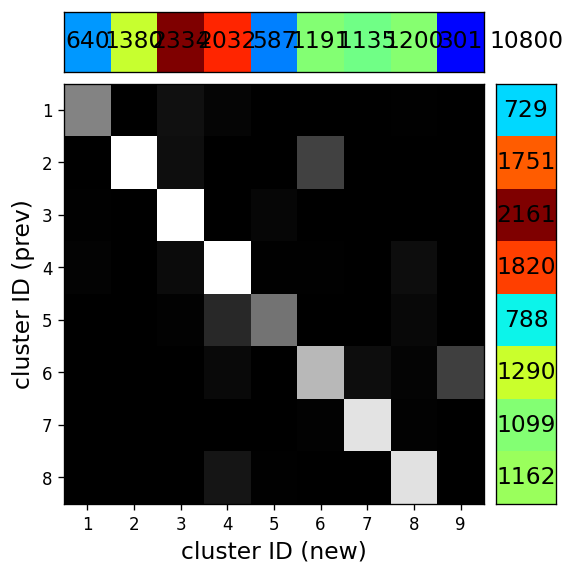

In [121]:
cont_mat, cid_set_prev, cid_set = gen_contingency_mat(prev_cid, cid)

plt.figure(dpi=120, figsize=(5, 5))
draw_contingency_table(cont_mat, cid_set_prev, cid_set, ["prev", "new"])
# draw_contingency_table(cont_mat, cid_set_sub, cid_set_tot, ["sub", "tot"])
# utils.save_fig("contingency_matrix", fdir="./fig")
plt.show()

### Show clustering result on parameter space

In [91]:
# get lines
def get_im_boundary(im):
    nb = im.shape[0]
    lines = []
    
    def is_out(nr, nc):
        return (nc < 0) or (nc >=nb) or (nr < 0) or (nr >= nb)
    
    for i in range(nb):
        for j in range(nb):
            for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                r, c = i+d[0], j+d[1]
                if is_out(r, c): continue
                
                if im[i, j] != im[r, c]:
                    if d[1] == 0:
                        lines.append([[j-0.5, j+0.5], [i+0.5*d[0], i+0.5*d[0]]])
                    else:
                        lines.append([[j+0.5*d[1], j+0.5*d[1]], [i-0.5, i+0.5]])
    return lines


def show_cluster_summary(cluster_id, wsets=None, max_cid=15, min_cid=1, sval=None, sth=0.2):
    
    num_w = 16
    num_r = 3
    
    len_p = 0.95/num_w
    len_r = 0.95/num_r

    xy = np.arange(15)

    lb_rank = ("Echelon 0", "Echelon 0.5", "Echelon 1")
    # lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    # lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    lb_w = [r"$\omega$=%.2f"%(x) for x in wsets]
    
    lines_cluster = []
    for idp in range(num_w):
        for idr in range(num_r):
            lines_cluster.append(get_im_boundary(cluster_id[:, :, idr, idp]))

    ax_sets = []
    # fig = plt.figure(dpi=120, figsize=(14, 6))
    fig = plt.figure(dpi=120, figsize=(20, 4))
    for idp in range(num_w):
        ax_sets.append([])
        for idr in range(num_r):
            ax = plt.axes(position=[0.025+len_p*idp, 0.025+(2-idr)*len_r, len_p, len_r])
            ax_sets[-1].append(ax)
            
            # im = cluster_data["im_stacks"][idr][idp].astype(float)
            im = cluster_id[:, :, idr, idp].astype(float)
            im[0, 0] = np.nan
            
            if sval is not None:
                im[sval[:, :, idr, idp] < sth] = np.nan
            
            hc.show_sq_cluster(im, x=xy, y=xy, cmap="turbo", cth=2, vmin=min_cid, vmax=max_cid, fontsize=12, aspect="auto")
            for l in lines_cluster[idp*num_r+idr]:
                plt.plot(l[0], l[1], 'w', lw=1)
            
            plt.xticks([0, 7, 14], labels=["", "", ""])
            plt.yticks([0, 7, 14], labels=["", "", ""])
            plt.xlim([-0, 14]); plt.ylim([0, 14])
            
            if idp == 0:
                plt.ylabel(lb_rank[idr], fontsize=15, style="italic")
            
            if idr == 0:
                plt.title(lb_w[idp], fontsize=15, style="italic")
            
            for n, k in enumerate(("left", "right", "bottom", "top")):
                ax.spines[k].set_color("k")
                ax.spines[k].set_linewidth(1.5)

    # plt.show()
    return fig, ax_sets

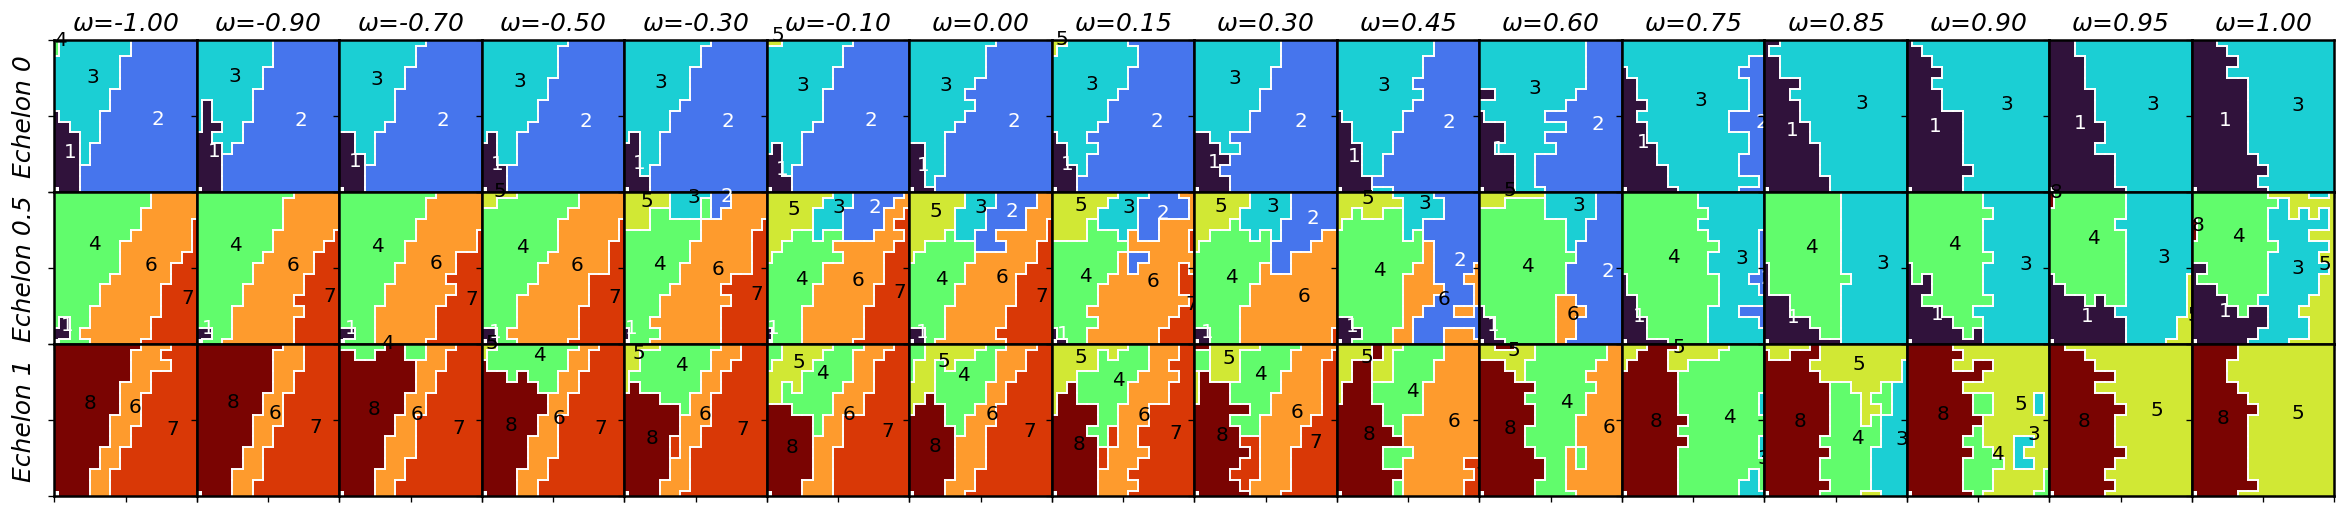

In [37]:
# wsets = prev_cid_sub.coords["w"]
wsets = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]
show_cluster_summary(np.reshape(prev_cid, (15, 15, 3, 16)), wsets=wsets, max_cid=8)
plt.show()

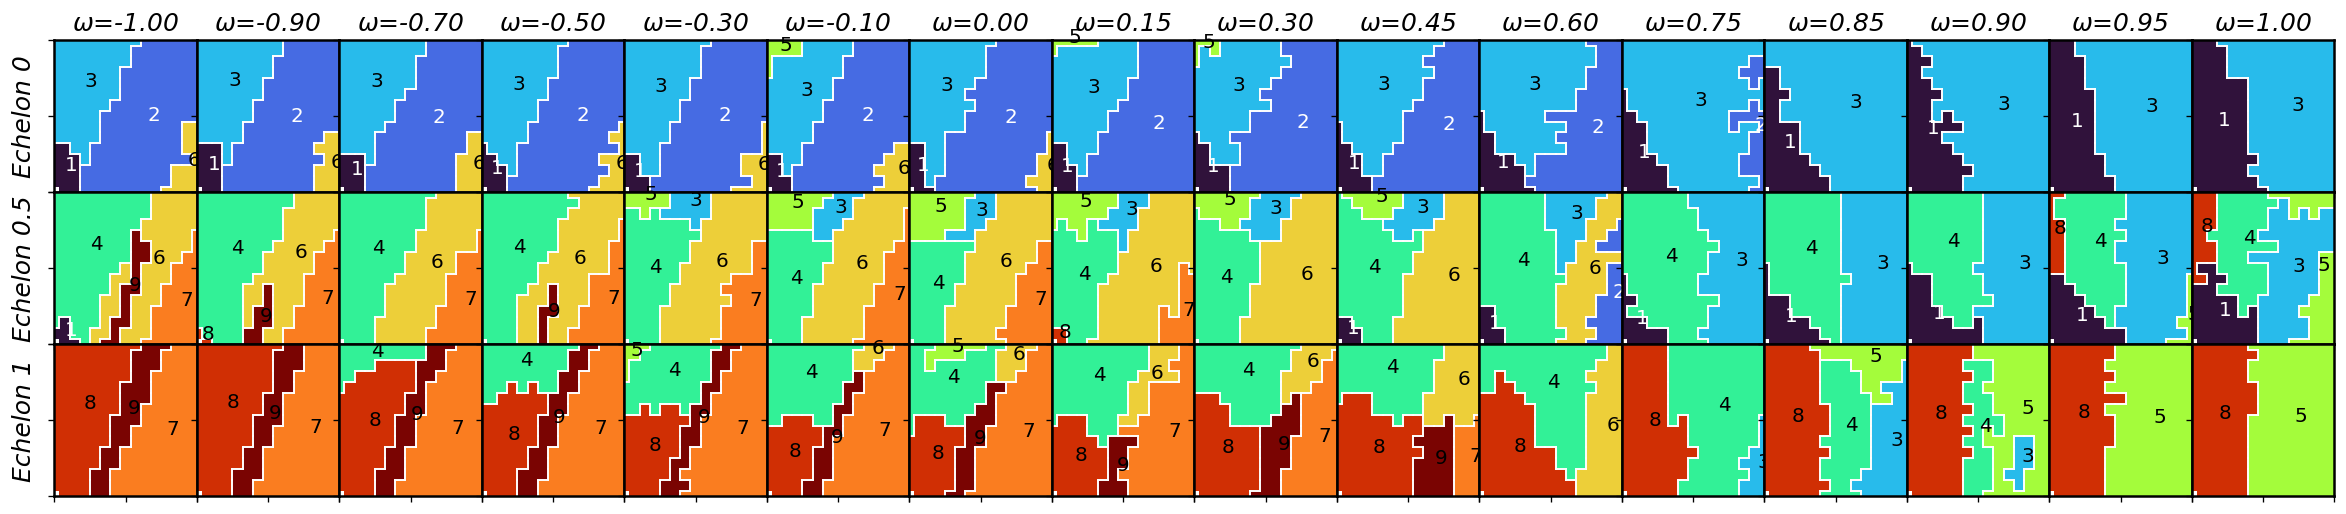

In [122]:
# wsets = prev_cid_sub.coords["w"]
wsets = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]
show_cluster_summary(np.reshape(cid, (15, 15, 3, 16)), wsets=wsets, max_cid=9)
plt.show()

# Show average feature value

In [179]:
def get_base_idx(ne):
    return 16*ne + np.arange(16)


data_partial = align_data_sub["data"][:-2, :]
lb_partial = align_data_sub["row_labels"][:-2]
N = len(lb_partial)

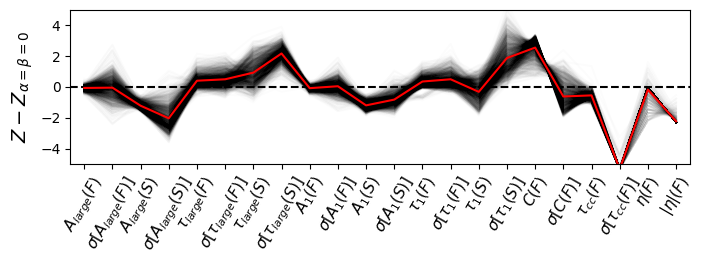

In [214]:
target_cid = 2
num_echelon, _ = np.histogram(echelon[cid == target_cid], [0, 1, 2, 3])
num_echelon_dom = np.argmax(num_echelon)
data_base = data_partial[:, get_base_idx(num_echelon_dom)].mean(axis=1)

plt.figure(figsize=(8, 2))
pobj = plt.plot(data_partial[:, cid==target_cid]-data_base[:, None], 'k', alpha=0.01)
pobj_mean, = plt.plot(data_partial[:, cid==target_cid].mean(axis=1)-data_base, 'r')
plt.plot([-0.5, N-0.5], [0, 0], 'k--', zorder=-1)
plt.xticks(np.arange(N), lb_partial, rotation=60, fontsize=11)
plt.ylim([-5, 5])
plt.xlim([-0.5, N-0.5])
plt.ylabel(r"$Z - Z_{\alpha=\beta=0}$", fontsize=14)

plt.show()

## Draw cluster properties

In [26]:
lb = align_data_sub["row_labels"]

for cid in range(1, 9):
    plt.figure(figsize=(8, 3))
    plt.plot(align_data_sub["data"][:, labels==cid], 'k', alpha=0.01)
    y = align_data_sub["data"][:, labels==cid]
    y = np.median(y, axis=1)
    plt.plot(y, 'ro-', lw=2)
    plt.ylim([-8, 8])
    plt.xticks(np.arange(len(lb)), lb, rotation=60)
    plt.tight_layout()
    # plt.savefig("./figs/cluster_features/cid%d.png"%(cid))
    plt.clf()

    # plt.show()

NameError: name 'labels' is not defined

<Figure size 800x300 with 0 Axes>

## Baseline

In [148]:
get_base_idx(0)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

# Draw on square lattice

In [ ]:
sz = [15, 15, 3, 16]
sq_cid = labels.reshape(*sz)

x = np.linspace(0, 1, 15) # beta
y = np.linspace(0, 2, 15) # alpha
r = [0, 0.5, 1]
w = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]

: 

In [ ]:
hc.show_cluster_summary(sq_cid, wsets=w, max_cid=9, min_cid=1, sval=None)
plt.show()

: 

## compare feature values with baseline value

### CID1

In [ ]:
y = align_data_sub["data"][:, labels==1]
yb = x_base[0]

x = np.arange(len(lb))
plt.figure()
plt.plot(x, y-yb[:, None], 'k', alpha=0.01)
plt.show()

: 

In [ ]:
plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0][labels==1], pca_proj[1][labels==1], c='k', s=1)
plt.show()

from sklearn.cluster import KMeans

kobj = KMeans(2, n_init=10)
lb_sub = kobj.fit_predict(data[:, labels==1].T.copy())

plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0][labels==1], pca_proj[1][labels==1], c=lb_sub, s=1)
plt.show()

: 

In [ ]:
y = align_data_sub["data"][:, labels==1]
yb = x_base[0]

x = np.arange(len(lb))
y1 = y[:, lb_sub == 0]
y2 = y[:, lb_sub == 1]

plt.figure(figsize=(6, 3))
plt.plot(x, y1-yb[:, None], 'k', alpha=0.01)
plt.plot(x, y2-yb[:, None], 'r', alpha=0.01)
plt.show()

: 

### CID2

In [ ]:
y = align_data_sub["data"][:, labels==2]
yb = x_base[2]

x = np.arange(len(lb))
plt.figure()
plt.plot(x, y-yb[:, None], 'k', alpha=0.01)
plt.show()

plt.figure()
plt.scatter(pca_proj[0][labels==2], pca_proj[1][labels==2], c='k', s=1)
plt.show()

: 

In [ ]:
plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0][labels==2], pca_proj[1][labels==2], c='k', s=1)
plt.show()

from sklearn.cluster import KMeans

kobj = KMeans(2, n_init=10)
lb_sub = kobj.fit_predict(data[:, labels==2].T.copy())

plt.figure(figsize=(3, 3))
plt.scatter(pca_proj[0][labels==2], pca_proj[1][labels==2], c=lb_sub, s=1)
plt.show()

: 

In [ ]:
y = align_data_sub["data"][:, labels==2]
yb = x_base[2]

x = np.arange(len(lb))
cmap = hhtools.get_palette("jet")
max_idx = 3

plt.figure(figsize=(6, 3))
for idx in range(max_idx):
    plt.plot(x, y[:, lb_sub==idx]-yb[:, None], c=cmap(idx/(max_idx-1)), alpha=0.1)

plt.show()

: 

: 